# Algorytm A*

### Ada Redlicka 258094

## 1. Działane

### 1.1. Algorytm

A* to algorytm do znajdowania najkrótszej ścieżki między wierzchołkami w grafie ważonym. Jest on zupełny i optymalny, tzn. zawsze znajduje najlepsze rozwiązanie (o ile ścieżka istnieje).  

Algorytm minimalizuje funkcję celu $f(x)$ zadaną następującym wzorem:

$$f(x) = g(x) + h(x),$$

gdzie

* $g(x)$ - funkcja kosztu, tj. rzeczywista droga pomiędzy wierzchołkiem początkowym a $x$;

* $h(x)$ - heurystyka, tj. przewidywana droga od $x$ do wierzchołka docelowego.

Kolejne kroki algorytmu polegają na przedłużeniu już utworzonej ścieżki o kolejny wierzchołek, w którym funkcja $f$ osiąga najmniejszą wartość. Algorytm kończy działanie, gdy dotrze do wierzchołka docelowego.

### 1.2. Heurystyka

Heurystyka $h(x)$ w algorytmie A* odgrywa kluczową rolę: to oszacowanie kosztu dotarcia z wierzchołka $x$ do celu. Nie musi być dokładne, ale powinna spełniać pewne warunki, aby A* zachował gwarancję znalezienia najkrótszej ścieżki. Są to:

* Dopuszczalność:

  Heurystyka nigdy nie powinna przeszacowywać rzeczywistego kosztu, czyli:
  
  $$h(x) \leq \text{koszt najkrótszej ścieżki z } x \text{ do celu.}$$

  Jeśli ten warunek jest spełniony, A* zawsze znajdzie optymalne rozwiązanie.

* Monotoniczność (spójność):

  Heurystyka jest spójna, jeśli dla każdej krawędzi $(x, y)$ zachodzi:

  $$h(x) \leq d(x,y) + h(y),$$

  gdzie $d(x, y)$ to koszt przejścia z $x$ do $y$ (faktyczna odległość). Spójność implikuje dopuszczalność i dodatkowo gwarantuje, że koszt ścieżki nie maleje.

Heurystykę dobieramy w zależności od problemu, który chcemy rozwiązać. Dosyć powszechne są np. odległość euklidesowa czy Manhattan. Dobór heurystyki ma bezpośredni wpływ na wydajność algorytmu. Lepsze (bliższe rzeczywistości) oszacowanie skraca liczbę przetwarzanych wierzchołków. Zbyt optymistyczna (np. $h(x) = 0$) prowadzi do zachowania jak w algorytmie Dijkstry. Z kolei zawyżona może spowodować, że A* nie znajdzie optymalnego rozwiązania.

## 2. Implementacja



In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy
from queue import PriorityQueue
import math
import time

In [ ]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle

    def draw(self):
      """
      Draws the graph using networkx.
      """
      G = nx.Graph()
      for u in self.graph:
        for v in self.graph[u]:
          G.add_edge(u, v)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()

    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree

    def connected_components(self):
      """
      Szuka spójnych skłądowych w (nieskierowanym) grafie.
      Zwraca listę zbiorów wierzchołków.
      Uwaga: zerowy element listy zawiera wszystkie wierzchołki grafu
      """
      def DFS(u):
        """
        Przechodzenie w głąb - metoda wewnętrzna
        """
        for w in self.graph[u]:
          if w not in VT[0]:    # w jeszcze nieodwiedzony
            VT[0].add(w)        # już odwiedzony
            VT[-1].add(w)       # w ostatniej (aktualnej) spójnej składowej
            DFS(w)
      """
      VT - lista zbiorów wierzchołków (drzew DFS).
      VT[0] - docelowo lista wszystkich wierzchołków w grafie.
      """
      VT = [set([])]
      for v in self.graph:
        if not v in VT[0]:  # v - nieodwiedzony
          VT[0].add(v)      # już odwiedzony
          VT.append(set([v])) # zalążek nowej spójnej składowej
          DFS(v)
      return VT

    def connected_components_graphs(self):
      """
      Zwraca listę spójnych składowych (jako grafów).
      """
      components = self.connected_components()  # lista zbiorów wierzchołków
      component_graphs = []                     # zalążek listy grafów
      for component in components[1:]:
        subgraph = Graph()
        for vertex in component:
          subgraph.graph[vertex] = self.graph[vertex].copy()
        component_graphs.append(subgraph)
      return component_graphs

    def distance(self, v):
      """
      Oblicza odległości z wierzhołka v do każdego osiąglanego wierzchołka w grafie.
      Używa BFS. Wynik podany jako słownik (indeksowany etykietami wierzchołków).
      """
      dist = {v: 0}   # zalążek słownika
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if not w in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist

In [ ]:
class WeigthtedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    # dict initializer
    @classmethod
    def from_dict(cls, graph, weights):
        return cls(graph, weights)

    # przedefiniowanie wypisywania grafów
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}({self.weights[(v, u)]})"
            res += "\n"
        return res

    def add_arc(self, arc, weight = 1):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        super().add_arc(arc)
        self.weights[arc] = weight

    def add_edge(self, edge, weight = 1):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        super().add_edge(edge)
        self.weights[edge] = weight
        self.weights[(v, u)] = weight

    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Wczytujemy graf z pliku
        """
        graph = WeigthtedGraph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) == 2:             # two words, the edge description
            if directed:
              graph.add_arc((words[0], words[1]))
            else:
              graph.add_edge((words[0], words[1]))
          elif len(words) >= 3:             # at least three words, first three are the weighted edge description
            if directed:
              graph.add_arc((words[0], words[1]), int(words[2]))
            else:
              graph.add_edge((words[0], words[1]), int(words[2]))
        file.close()
        return graph

    def draw(self, directed=0, heuristic=None):
      """
      Rysowanie grafu ważonego. Jeśli directed=1, rysuje graf skierowany.
      Jeśli podano słownik heuristic, dodaje heurystyki (na czerwono) obok wierzchołków.
      """
      G = nx.DiGraph() if directed else nx.Graph()

      # Dodanie krawędzi i wag
      for u in self.graph:
          for v in self.graph[u]:
              if not directed and (v, u) in G.edges:
                  continue
              G.add_edge(u, v, weight=self.weights[(u, v)])

      # Rozmieszczenie wierzchołków
      pos = nx.spring_layout(G)

      # Rysowanie wierzchołków i krawędzi
      nx.draw(
          G, pos, with_labels=True,
          arrows=bool(directed),
          **({"connectionstyle": 'arc3,rad=0.1'} if directed else {})
      )

      # Wagi krawędzi
      labels = nx.get_edge_attributes(G, 'weight')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

      # Heurystyki (jeśli podano)
      if heuristic:
          heur_labels = {v: f"h={round(heuristic[v], 2)}" for v in G.nodes if v in heuristic}
          nx.draw_networkx_labels(G, pos, labels=heur_labels, font_color='red', verticalalignment='bottom')

      plt.show()


    def min_spanning_tree(self):
      """
      Oblicza drzewo rozpinające wg algorytmu Jarnika-Prima.
      """
      for v in self.graph:
        break
      wtree = WeigthtedGraph({v:[]}, {})
      total = 0   # całkowita waga
      q = PriorityQueue()
      for u in self.graph[v]:
        q.put((self.weights[(v, u)], v, u))
      while not q.empty():
        w, v, u = q.get()
        if not u in wtree.graph:
          wtree.add_edge((v, u), w)
          total += w
          for x in self.graph[u]:
            if not x in wtree.graph:
              q.put((self.weights[(u, x)], u, x))
      if len(wtree.graph) != len(self.graph):
        print("Graf jest niespójny. Zwrócopne drzewo dla jednej spójnej składowej.")
      return wtree, total


    def Dijkstra(self, s):
      """
      Algorytm Dijkstry. Wyznacza najkrótsze ścieżki z wierzchołka s
      """
      # Init
      dist = {}
      pred = {}
      for v in self.graph:
        dist[v] = float("inf")
        pred[v] = None
      dist[s] = 0
      q = PriorityQueue()
      q.put((dist[s], s))
      while not q.empty():
        d, u = q.get()
        if dist[u] >= d:
          for v in self.graph[u]:
            if dist[v] > dist[u] + self.weights[(u, v)]:
              dist[v] = dist[u] + self.weights[(u, v)]
              pred[v] = u
              q.put((dist[v], v))
      return dist, pred

    def Dijkstra_path(self, start, goal):
      """
      Algorytm Dijkstry — zwraca najkrótszą ścieżkę i koszt z wierzchołka start do goal.
      """
      dist = {v: float("inf") for v in self.graph}
      pred = {v: None for v in self.graph}
      dist[start] = 0

      q = PriorityQueue()
      q.put((0, start))

      while not q.empty():
          d, u = q.get()
          if u == goal:
              break
          if dist[u] < d:
              continue
          for v in self.graph[u]:
              alt = dist[u] + self.weights[(u, v)]
              if alt < dist[v]:
                  dist[v] = alt
                  pred[v] = u
                  q.put((alt, v))

      # Odtworzenie ścieżki
      if dist[goal] == float("inf"):
          return float("inf"), []

      path = []
      current = goal
      while current is not None:
          path.append(current)
          current = pred[current]
      path.reverse()

      return dist[goal], path

    def network_flow(self):
      """
      Zwraca sieć przepływową zrobioną ze zwykłego grafu skierowanego, ważonego.
      Dodaje łuki wsteczne z przepustowością 0.
      """
      network = WeigthtedGraph()
      for u in self.graph:
        for v in self.graph[u]:
          network.add_edge((u, v), 0)
      for u in self.graph:
        for v in self.graph[u]:
          network.weights[(u,v)] = self.weights[(u,v)]
      return network


    def maxflow_EK(self, s, t):
      """
      Algorytm Edmondsa-Karpa znajduje maksymalny przepływ z wierzchołka s do t.
      """
      network = self.network_flow()
      n = len(network.graph)
      flow = {xx: 0 for xx in network.weights}
      # wyliczamy ścieżki powiększające przez BFS
      while True:
        pred = {s: None}  # słownik poprzedników
        cap = {s: float("inf")}  # słownik do przepustowości ścieżki
        queue = [s]
        while len(queue) > 0:
          u = queue.pop(0)
          for v in network.graph[u]:
            if (not v in pred) and network.weights[(u, v)] - flow[(u, v)] > 0:
              pred[v] = u
              cap[v] = min(cap[u], network.weights[(u, v)] - flow[(u, v)])
              if v == t:
                break
              else:
                queue.append(v)
          if v == t:
            break
        if not t in pred:     # koniec - nie ma s->t ścieżki
          break
        else:
          # przetwarzamy ścieżkę powiększającą
          v = t
          while v != s:
            u = pred[v]
            flow[(u, v)] += cap[t]
            flow[(v, u)] -= cap[t]
            v = u
      return flow

    def A_star(self, start, goal, heuristic = None):
      """
      Algorytm A* — wyznacza najkrótszą ścieżkę z wierzchołka start do goal.
      heuristic: słownik heurystyk (estymaty odległości z każdego wierzchołka do goal).
                 Jeśli None, to przyjmowana jest heurystyka zerowa (jak w Dijkstrze).
      Zwraca: (koszt, ścieżka jako lista wierzchołków)
      """
      if heuristic is None:
          heuristic = {v: 0 for v in self.graph}  # domyślnie: h ≡ 0

      closedset = set()  # zbiór wierzchołków przejrzanych
      openset = PriorityQueue()
      openset.put((heuristic[start], start))  # zbiór wierzchołków nieodwiedzonych, sąsiadujących z odwiedzonymi

      came_from = {}  # zapisuje z którego wierzchołka doszliśmy do danego
      g = {v: float("inf") for v in self.graph}
      g[start] = 0

      f = {v: float("inf") for v in self.graph}
      f[start] = heuristic[start]

      while not openset.empty():
          _, current = openset.get()

          if current in closedset:
              continue  # pomijamy już odwiedzone

          if current == goal:
              # Rekonstrukcja ścieżki
              path = [current]
              while current in came_from:
                  current = came_from[current]
                  path.append(current)
              path.reverse()
              return g[goal], path

          closedset.add(current)

          for neighbor in self.graph[current]:
              if neighbor in closedset:
                  continue
              tentative_g = g[current] + self.weights[(current, neighbor)]
              if tentative_g < g[neighbor]:
                  came_from[neighbor] = current
                  g[neighbor] = tentative_g
                  f[neighbor] = tentative_g + heuristic.get(neighbor, float("inf"))
                  openset.put((f[neighbor], neighbor))

      return float("inf"), []  # jeśli nie znaleziono ścieżki



In [ ]:
def euclidean_heuristic(positions: dict, goal):
    """
    Oblicza heurystykę euklidesową do wierzchołka goal na podstawie współrzędnych.

    positions: dict {vertex: (x, y)}
    goal: cel
    """
    hx, hy = positions[goal]
    heuristic = {}
    for v, (x, y) in positions.items():
        heuristic[v] = math.sqrt((x - hx) ** 2 + (y - hy) ** 2)
    return heuristic

def manhattan_heuristic(positions: dict, goal):
    """
    Oblicza heurystykę Manhattan do wierzchołka goal na podstawie współrzędnych.

    positions: dict {vertex: (x, y)}
    goal: cel
    """
    hx, hy = positions[goal]
    heuristic = {}
    for v, (x, y) in positions.items():
        heuristic[v] = abs(x - hx) + abs(y - hy)
    return heuristic

## 3. Przykłady zastosowania

Koszt: 7
Ścieżka: ['A', 'B', 'C', 'D']


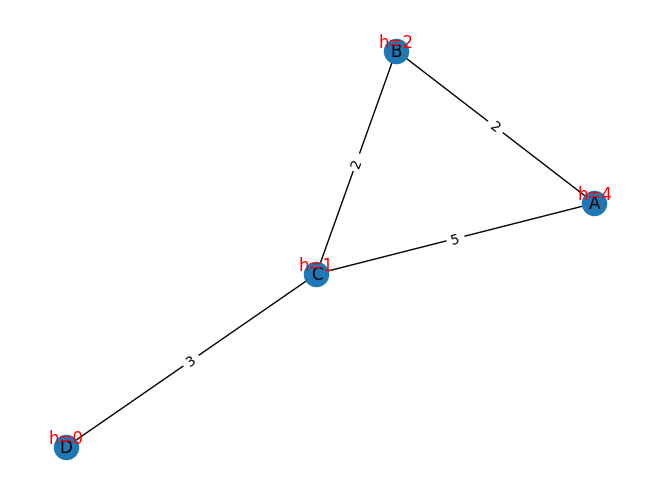

In [ ]:
# 1. Inicjalizacja grafu
G = WeigthtedGraph()

# 2. Dodanie krawędzi
G.add_edge(("A", "B"), 2)
G.add_edge(("B", "C"), 2)
G.add_edge(("A", "C"), 5)
G.add_edge(("C", "D"), 3)

# 3. Heurystyka
heuristic = {"A": 4, "B": 2, "C": 1, "D": 0}

# 4. Uruchomienie A* i wyniki
cost, path = G.A_star("A", "D", heuristic)
print("Koszt:", cost)
print("Ścieżka:", path)

# 5. Wizualizacja grafu
G.draw(heuristic=heuristic)

In [ ]:
# Pozycje wierzchołków (do heurystyki liczonej automatycznie)
positions = {
    "A": (0, 0),
    "B": (1, 1),
    "C": (2, 0),
    "D": (0, -1),
}

goal = "C"
heuristic = manhattan_heuristic(positions, goal)
print(heuristic)

{'A': 2, 'B': 2, 'C': 0, 'D': 3}


In [ ]:
cost, path = G.A_star("A", "C", heuristic)
print(cost)
print(path)

4
['A', 'B', 'C']


In [ ]:
# Porównanie z algorytmem Dijkstry
cost, path = G.Dijkstra_path("A", "C")
print(cost)
print(path)

4
['A', 'B', 'C']


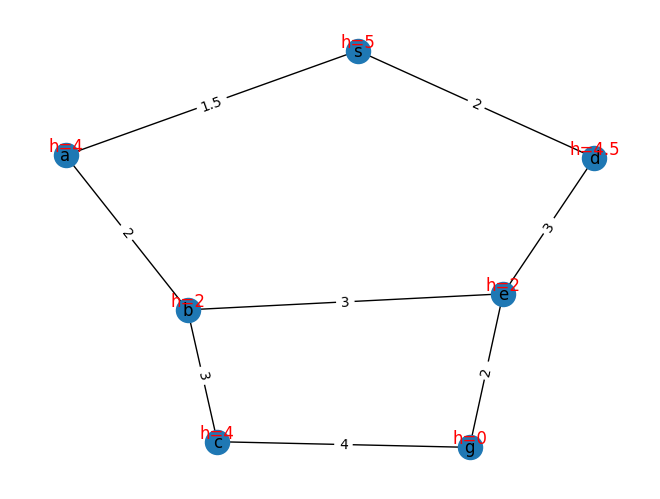

In [ ]:
G = WeigthtedGraph()

G.add_edge(("s", "a"), 1.5)
G.add_edge(("s", "d"), 2)
G.add_edge(("a", "b"), 2)
G.add_edge(("b", "c"), 3)
G.add_edge(("c", "g"), 4)
G.add_edge(("b", "e"), 3)
G.add_edge(("d", "e"), 3)
G.add_edge(("e", "g"), 2)

heuristic = {
    "a": 4,
    "b": 2,
    "c": 4,
    "d": 4.5,
    "e": 2,
    "g": 0,
    "s": 5
}

G.draw(heuristic=heuristic)

Algorytm wylicza funkcję celu w następujący sposób:
1. $f(a) = 1,5 + 4 = 5,5$ -> wybiera $a$

  $f(d) = 2 + 4,5 = 6,5$

2. $f(b) = 3,5 + 2 = 5,5$ -> wybiera $b$

  $f(d) = 6,5$

3. $f(c) = 6,5 + 4 = 10,5$

  $f(d) = 6,5$ -> wraca do $d$ bo tam funkcja celu była mniejsza niż w $c$

4. $f(e) = 5 + 2 = 7$ -> wybiera $e$

  $f(c) = 10,5$

5. $f(g) = 5 + 2 = 7$ -> wybiera $g$ i dotarł do celu.
  

In [ ]:
cost, path = G.A_star("s", "g", heuristic)
print("Koszt:", cost)
print("Ścieżka:", path)

Koszt: 7
Ścieżka: ['s', 'd', 'e', 'g']


In [ ]:
cost, path = G.Dijkstra_path("s", "g")
print("Koszt:", cost)
print("Ścieżka:", path)

Koszt: 7
Ścieżka: ['s', 'd', 'e', 'g']


### Przykład - najkrótsza droga między miastami

Szukamy najkrótszej drogi prowadzącej z Gdańska do Krakowa. Konstruujemy graf, w którym wagami będą rzeczywiste odległości między miastami, natomiast heurystyka to odległość w linii prostej między miastami a Krakowem.

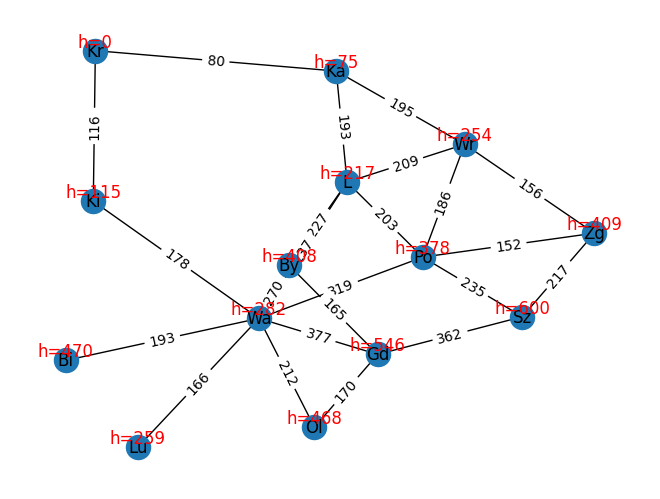

In [ ]:
edges = [
    ("Sz", "Po", 235),
    ("Sz", "Zg", 217),
    ("Sz", "Gd", 362),
    ("Gd", "By", 165),
    ("Gd", "Wa", 377),
    ("Gd", "Ol", 170),
    ("By", "Wa", 270),
    ("By", "L", 227),
    ("Po", "L", 203),
    ("Po", "Zg", 152),
    ("Po", "Wr", 186),
    ("Po", "Wa", 319),
    ("Zg", "Wr", 156),
    ("Wr", "L", 209),
    ("Wr", "Ka", 195),
    ("Ka", "L", 193),
    ("Ka", "Kr", 80),
    ("Kr", "Ki", 116),
    ("L", "Wa", 137),
    ("Wa", "Ol", 212),
    ("Wa", "Bi", 193),
    ("Wa", "Lu", 166),
    ("Wa", "Ki", 178)
]

G = WeigthtedGraph()

# Dodajemy krawędzie do grafu
for u, v, w in edges:
    G.add_edge((u, v), w)

heuristic = {
    "Sz": 600,
    "Gd": 546,
    "Ol": 468,
    "Bi": 470,
    "Wa": 282,
    "By": 408,
    "Po": 378,
    "Zg": 409,
    "Wr": 254,
    "Ka": 75,
    "Kr": 0,
    "Ki": 115,
    "Lu": 259,
    "L": 217
}

G.draw(heuristic=heuristic)

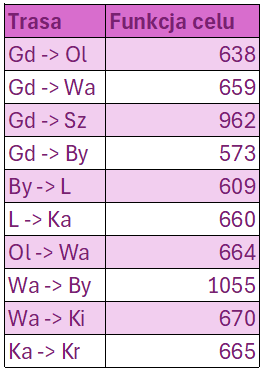

In [1]:
from PIL import Image
Image.open("tabelka.png")

Na początek nasz algorytm będzie szedł dobrze, tj. ścieżką Gd -> By -> L, jednak przy przejściu L -> Ka otrzymamy większą funkcję celu $(f(x) = 660)$ niż w przypadku przejścia Gd -> Ol $(f(x) = 638)$. Wówczas nasz algorytm się cofnie do tego węzła i zacznie przeszukiwać nową ścieżkę. Podobnych nawrotów może być więcej, jednak ostatecznie nasz algorytm wróci na pierwotną ścieżkę i dokończy drogę do Krakowa przez Katowice.

In [ ]:
cost, path = G.A_star("Gd", "Kr", heuristic)
print("Koszt:", cost)
print("Ścieżka:", path)

Koszt: 665
Ścieżka: ['Gd', 'By', 'L', 'Ka', 'Kr']


In [ ]:
cost, path = G.Dijkstra_path("Gd", "Kr")
print("Koszt:", cost)
print("Ścieżka:", path)

Koszt: 665
Ścieżka: ['Gd', 'By', 'L', 'Ka', 'Kr']


### Przykład ze złą heurystyką

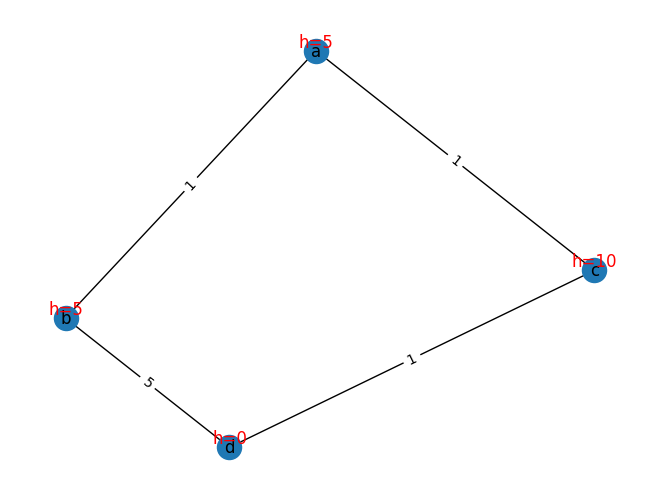

In [ ]:
G = WeigthtedGraph()

G.add_edge(("a", "b"), 1)
G.add_edge(("a", "c"), 1)
G.add_edge(("b", "d"), 5)
G.add_edge(("c", "d"), 1)

heuristic = {
    "a": 5,
    "b": 5,
    "c": 10,  # zawyżona heurystyka
    "d": 0
}

G.draw(heuristic=heuristic)

In [ ]:
cost, path = G.A_star("a", "d", heuristic)
print("Koszt:", cost)
print("Ścieżka:", path)

Koszt: 6
Ścieżka: ['a', 'b', 'd']


In [ ]:
cost, path = G.Dijkstra_path("a", "d")
print("Koszt:", cost)
print("Ścieżka:", path)

Koszt: 2
Ścieżka: ['a', 'c', 'd']


W powyższym przykładzie heurystyka przekracza rzeczywisty minimalny koszt dojścia do celu. Algorytm pomija optymaną ścieżkę, bo heurystyka fałszywie go zniechęciła do jej rozważania.

### Przykład kiedy nie da się znaleźć ścieżki

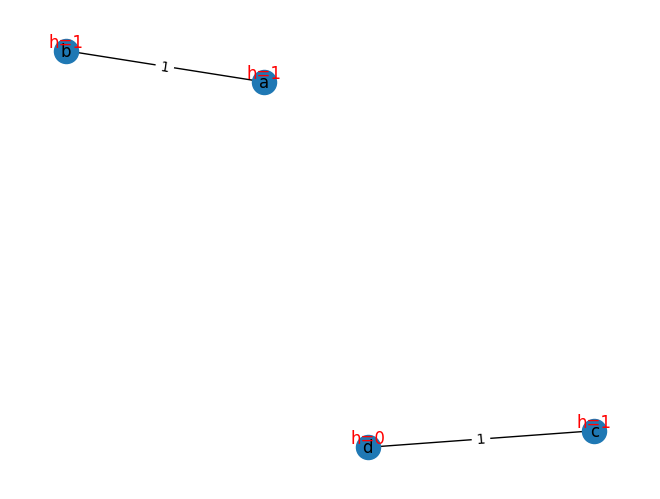

In [ ]:
G = WeigthtedGraph()

G.add_edge(("a", "b"), 1)
G.add_edge(("c", "d"), 1)

heuristic = {
    "a": 1,
    "b": 1,
    "c": 1,
    "d": 0
}

G.draw(heuristic=heuristic)

In [ ]:
cost, path = G.A_star("a", "d", heuristic)
print("Koszt:", cost)
print("Ścieżka:", path)

Koszt: inf
Ścieżka: []


W powyższym przykładzie nie da się znaleźć minimalnej ścieżki, ponieważ nie ma połączenia między wierchołkiem $a$ i $d$.

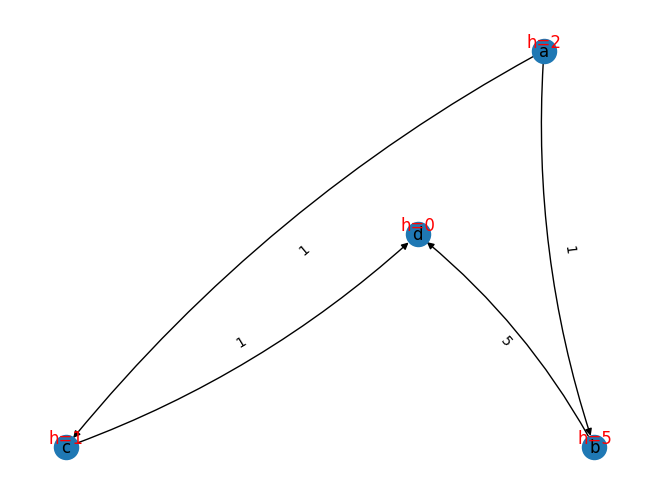

In [ ]:
G = WeigthtedGraph()

G.add_arc(("a", "b"), 1)
G.add_arc(("a", "c"), 1)
G.add_arc(("b", "d"), 5)
G.add_arc(("c", "d"), 1)

heuristic = {
    "a": 2,
    "b": 5,
    "c": 1,
    "d": 0
}

G.draw(directed=1, heuristic=heuristic)

In [ ]:
cost, path = G.A_star("d", "a", heuristic)
print("Koszt:", cost)
print("Ścieżka:", path)

Koszt: inf
Ścieżka: []


W tym przypadku istnieje najkrótsza ścieżka z $a$ do $d$, ale nie istnieje najkrótsza ścieżka z $d$ do $a$ ponieważ graf jest skierowany i nie da się przejść z $d$ do $a$.

### Porównanie czasu działania A* i Dijkstry

A*:
  Koszt ścieżki: 3.0
  Długość ścieżki: 3
  Czas wykonania: 0.0001 s
Dijkstra:
  Koszt ścieżki: 3.0
  Długość ścieżki: 3
  Czas wykonania: 0.0002 s


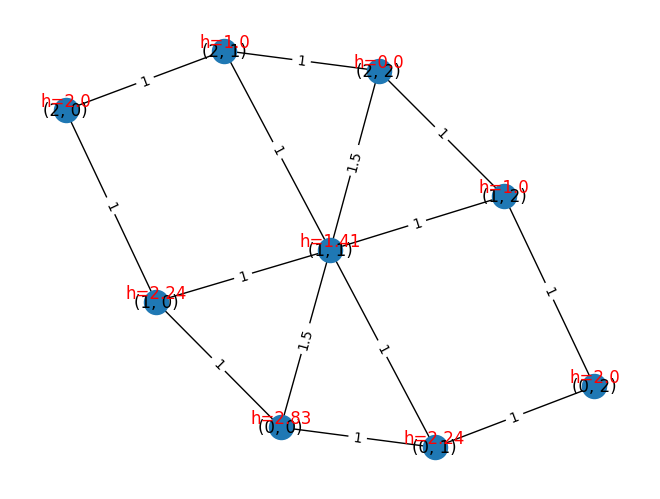

In [ ]:
def build_grid_graph(n):
    G = WeigthtedGraph()
    for x in range(n):
        for y in range(n):
            v = (x, y)
            # Połączenia 4-kierunkowe
            for dx, dy in [(1, 0), (0, 1)]:
                nx, ny = x + dx, y + dy
                if nx < n and ny < n:
                    u = (nx, ny)
                    G.add_edge((v, u), 1)

            # Dodatkowe połączenie przekątne: (x,y) <-> (x+1,y+1)
            if x == y and x + 1 < n and y + 1 < n:
                diag = (x + 1, y + 1)
                G.add_edge((v, diag), 1.5)
    return G

n = 3
G = build_grid_graph(n)

start_node = (0, 0)
goal_node = (n-1, n-1)
positions = {(x, y): (x, y) for x in range(n) for y in range(n)}
heuristic = euclidean_heuristic(positions, goal_node)

start = time.time()
cost_a, path_a = G.A_star(start_node, goal_node, heuristic)
end = time.time()
print("A*:")
print(f"  Koszt ścieżki: {cost_a}")
print(f"  Długość ścieżki: {len(path_a)}")
print(f"  Czas wykonania: {end - start:.4f} s")

start = time.time()
cost_d, path_d = G.Dijkstra_path(start_node, goal_node)
end = time.time()
print("Dijkstra:")
print(f"  Koszt ścieżki: {cost_d}")
print(f"  Długość ścieżki: {len(path_d)}")
print(f"  Czas wykonania: {end - start:.4f} s")
G.draw(heuristic=heuristic)

In [ ]:
n = 1000
G = build_grid_graph(n)

start_node = (0, 0)
goal_node = (n-1, n-1)
positions = {(x, y): (x, y) for x in range(n) for y in range(n)}
heuristic = euclidean_heuristic(positions, goal_node)

start = time.time()
cost_a, path_a = G.A_star(start_node, goal_node, heuristic)
end = time.time()
print("A*:")
print(f"  Koszt ścieżki: {cost_a}")
print(f"  Długość ścieżki: {len(path_a)}")
print(f"  Czas wykonania: {end - start:.4f} s")

start = time.time()
cost_d, path_d = G.Dijkstra_path(start_node, goal_node)
end = time.time()
print("Dijkstra:")
print(f"  Koszt ścieżki: {cost_d}")
print(f"  Długość ścieżki: {len(path_d)}")
print(f"  Czas wykonania: {end - start:.4f} s")

A*:
  Koszt ścieżki: 1498.5
  Długość ścieżki: 1000
  Czas wykonania: 6.6033 s
Dijkstra:
  Koszt ścieżki: 1498.5
  Długość ścieżki: 1000
  Czas wykonania: 17.2485 s


In [ ]:
# Heurystyka ustawiona na 0 — A* zachowuje się jak Dijkstra
start = time.time()
cost_a, path_a = G.A_star(start_node, goal_node)
end = time.time()
print("A*:")
print(f"  Koszt ścieżki: {cost_a}")
print(f"  Długość ścieżki: {len(path_a)}")
print(f"  Czas wykonania: {end - start:.4f} s")

A*:
  Koszt ścieżki: 1498.5
  Długość ścieżki: 1000
  Czas wykonania: 19.3967 s
